<a href="https://colab.research.google.com/github/hhc703/deep-learning/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

순환 신경망

데이터 셋 준비

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all),(x_test, y_test) = imdb.load_data(skip_top=20, num_words=100) #imdb 인터넷 영화 데이터베이스에서 수집한 영화 리뷰 데이터

In [18]:
print(x_train_all.shape, y_train_all.shape) #훈련 세트 크기 확인

(25000,) (25000,)


In [19]:
print(x_train_all[0]) #훈련 세트 샘플 확인

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [20]:
for i in range(len(x_train_all)): #2까지의 수 잘라내기
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]
print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [21]:
word_to_index = imdb.get_word_index() #어휘 사전 받기
word_to_index['movie']

17

In [22]:
index_to_word = {word_to_index[k]: k for k in word_to_index} #훈련 세트 데이터 영단어로 변환

for w in x_train_all[0]:
  print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [23]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [24]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [25]:
#검증 세트 준비
np.random.seed(42)  
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [26]:
from tensorflow.keras.preprocessing import sequence #샘플의 길이를 맞추기 위한 도구

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [27]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [28]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [29]:
#원 - 핫 인코딩
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [30]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [31]:
print(x_train_onehot.nbytes)

800000000


순환 신경망 클래스 구현

In [40]:
class RecurrentNetwork:

  def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
    self.n_cells = n_cells        #셀 개수
    self.batch_size = batch_size  #배치 크기
    self.w1h = None               #은닉 상태에 대한 가중치
    self.w1x = None               #입력에 대한 가중치
    self.b1 = None                #순환층의 절편
    self.w2 = None                #출력층의 가중치
    self.b2 = None                #출력층의 절편
    self.h = None                 #순환층의 활성화 출력
    self.losses = []              #훈련 손실
    self.val_losses = []          #검증 손실
    self.lr = learning_rate       #학습률

  def forpass(self, x):
    self.h = [np.zeros((x.shape[0], self.n_cells))] #은닉 상태 초기화
    #배치 차원과 타임 스텝 차원 바꾸기
    seq = np.swapaxes(x, 0, 1)
    #순환층의 선형식 계산
    for x in seq:
      z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
      h = np.tanh(z1)                     #활성화 함수 적용
      self.h.append(h)                    #역전파를 위해 은닉 상태 저장
      z2 = np.dot(h, self.w2) + self.b2   #출력층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)    #샘플 개수

    #출력층의 가중치와 절편에 대한 그레이디언트 계산
    w2_grad = np.dot(self.h[-1].T, err) / m
    b2_grad = np.sum(err) / m
    #배치 차원과 타임 스텝 차원 바꾸기
    seq = np.swapaxes(x, 0, 1)

    w1h_grad = w1x_grad = b1_grad = 0
    #셀 직전까지 그레이디언트 계산
    err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
    #모든 타임 스텝을 거슬러 가면서 그레이디언트 전파
    for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
      w1h_grad += np.dot(h.T, err_to_cell)
      w1x_grad += np.dot(x.T, err_to_cell)
      b1_grad += np.sum(err_to_cell, axis=0)
      #이전 타임 스텝의 셀 직전까지 그레이디언트 계산
      err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)

    w1h_grad /= m
    w1x_grad /= m
    b1_grad /= m
    
    return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def init_weights(self, n_features, n_classes):
    orth_init = tf.initializers.Orthogonal()
    glorot_init = tf.initializers.GlorotUniform()

    self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()  #(셀 개수, 셀 개수)
    self.w1x = glorot_init((n_features, self.n_cells)).numpy()  #(특성 개수, 셀 개수)
    self.b1 = np.zeros(self.n_cells)                            #은닉층의 크기
    self.w2 = glorot_init((self.n_cells, n_classes)).numpy()    #(셀 개수, 클래스 개수)
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val=y_val.reshape(-1, 1)
    np.random.seed(42)
    self.init_weights(x.shape[2], y.shape[1])   #은닉층과 출력층의 가중치 초기화

    #에포크만큼 반복
    for i in range(epochs):
      print('에포크', i, end=' ')
      #제너레이터 함수에서 반환한 미니 배치 순환
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        a = self.training(x_batch, y_batch)
        #안전한 로그 계산을 위해 클리핑
        a = np.clip(a, 1e-10, 1-1e-10)
        #로그 손실과 규제 손실을 더하여 리스트에 추가
        loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
        batch_losses.append(loss)
      print()
      self.losses.append(np.mean(batch_losses))
      #검증 세트에 대한 손실 계산
      self.update_val_loss(x_val, y_val)

  #미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size  #미니 배치 횟수
    if length % self.batch_size:
      bins += 1                       #나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))  #인덱스 섞기
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end]    #batch_size만큼 슬라이싱하여 반환

  def training(self, x, y):
    m = len(x)            #샘플 개수 저장
    z = self.forpass(x)   #정방향 계산 수행
    a = self.sigmoid(z)   #활성화 함수 적용
    err = -(y - a)        #오차 계산
    #오차 역전파하여 그레이디언트 계산
    w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    #셀의 가중치와 절편 업데이트
    self.w1h -= self.lr * w1h_grad
    self.w1x -= self.lr * w1x_grad
    self.b1 -= self.lr * b1_grad
    #출력층의 가중치와 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x) #정방향 계산 수행
    return z > 0        #스텝함수 적용

  def score(self, x, y):
    #예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
    return np.mean(self.predict(x) == y.reshape(-1, 1))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)         #정방향 계산 수행
    a = self.sigmoid(z)             #활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10)  #출력값 클리핑
    val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append(val_loss)

In [41]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

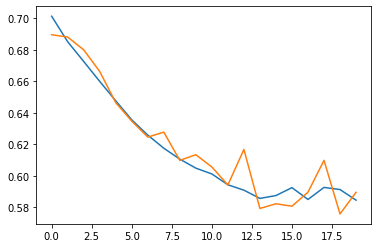

In [42]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [43]:
rn.score(x_val_onehot, y_val)

0.6808

텐서플로로 순환 신경망 만들기

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [45]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 15s 20ms/step - loss: 0.7015 - accuracy: 0.5017 - val_loss: 0.6954 - val_accuracy: 0.5132
Epoch 2/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6916 - accuracy: 0.5257 - val_loss: 0.6897 - val_accuracy: 0.5332
Epoch 3/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6876 - accuracy: 0.5420 - val_loss: 0.6815 - val_accuracy: 0.5636
Epoch 4/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6748 - accuracy: 0.5788 - val_loss: 0.6547 - val_accuracy: 0.6196
Epoch 5/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6511 - accuracy: 0.6198 - val_loss: 0.6663 - val_accuracy: 0.5886
Epoch 6/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6310 - accuracy: 0.6502 - val_loss: 0.6375 - val_accuracy: 0.6376
Epoch 7/20
625/625 [==============================] - 12s 20ms/step - loss: 0.6144 - accuracy: 0.6611 - val_loss: 0.5910 - val_accuracy:

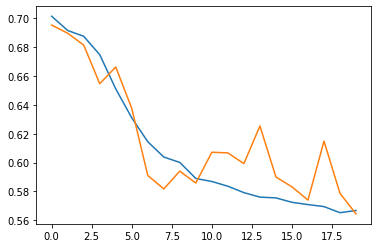

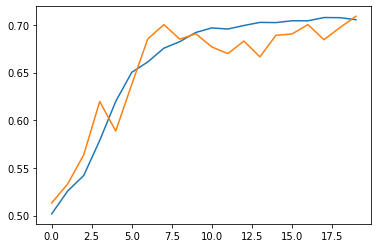

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [49]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)

print(accuracy)

0.7089999914169312


임베딩층으로 성능 높이기

In [50]:
from tensorflow.keras.layers import Embedding

In [51]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [52]:
maxlen = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [53]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 328       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 14s 20ms/step - loss: 0.5185 - accuracy: 0.7404 - val_loss: 0.4398 - val_accuracy: 0.8084
Epoch 2/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3947 - accuracy: 0.8333 - val_loss: 0.4176 - val_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3558 - accuracy: 0.8522 - val_loss: 0.4168 - val_accuracy: 0.8180
Epoch 4/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3260 - accuracy: 0.8669 - val_loss: 0.4291 - val_accuracy: 0.8120
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2985 - accuracy: 0.8828 - val_loss: 0.4234 - val_accuracy: 0.8228
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 0.2809 - accuracy: 0.8878 - val_loss: 0.4377 - val_accuracy: 0.8208
Epoch 7/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2575 - accuracy: 0.9004 - val_loss: 0.4476 - val_accuracy:

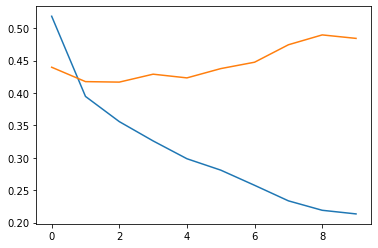

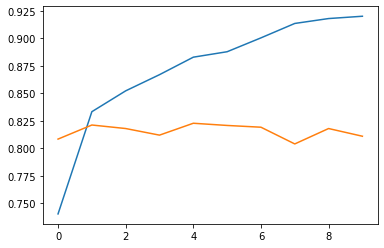

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [56]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8109999895095825


LSTM 순환 신경망

In [57]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 lstm (LSTM)                 (None, 8)                 1312      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 19s 28ms/step - loss: 0.4607 - accuracy: 0.7905 - val_loss: 0.3783 - val_accuracy: 0.8378
Epoch 2/10
625/625 [==============================] - 17s 27ms/step - loss: 0.3391 - accuracy: 0.8572 - val_loss: 0.3624 - val_accuracy: 0.8386
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.3084 - accuracy: 0.8702 - val_loss: 0.3527 - val_accuracy: 0.8432
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2899 - accuracy: 0.8798 - val_loss: 0.3691 - val_accuracy: 0.8402
Epoch 5/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2759 - accuracy: 0.8868 - val_loss: 0.3689 - val_accuracy: 0.8382
Epoch 6/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2651 - accuracy: 0.8909 - val_loss: 0.3795 - val_accuracy: 0.8364
Epoch 7/10
625/625 [==============================] - 17s 28ms/step - loss: 0.2546 - accuracy: 0.8949 - val_loss: 0.3959 - val_accuracy:

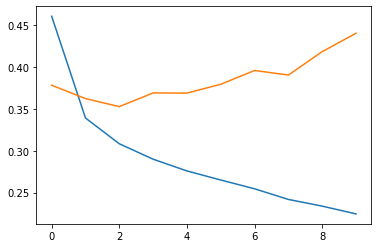

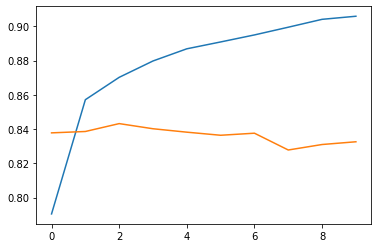

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [60]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8325999975204468
